In [10]:
from bayesians_learning import *
from qubit import *
from experiment import *
from tqdm import tqdm
import math

  0%|          | 0/12 [00:00<?, ?it/s]

1001


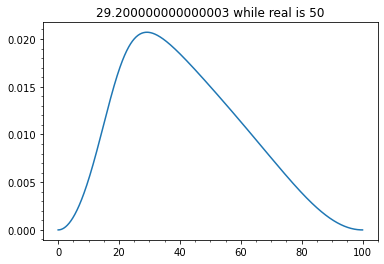

  8%|▊         | 1/12 [00:05<01:00,  5.51s/it]

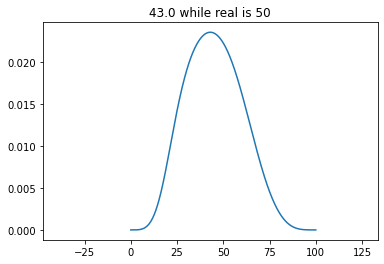

 17%|█▋        | 2/12 [00:11<00:55,  5.57s/it]

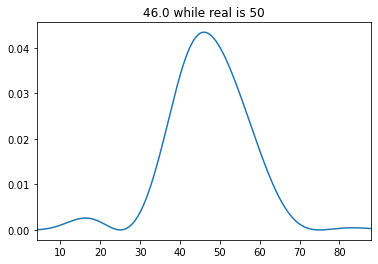

 25%|██▌       | 3/12 [00:16<00:50,  5.61s/it]

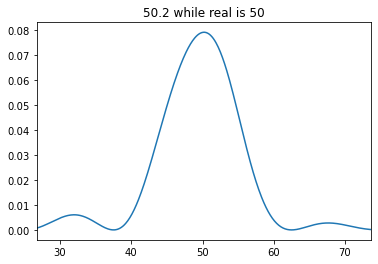

 33%|███▎      | 4/12 [00:22<00:45,  5.65s/it]

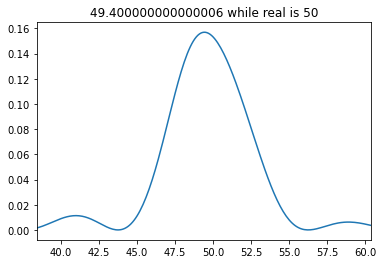

 42%|████▏     | 5/12 [00:28<00:39,  5.69s/it]

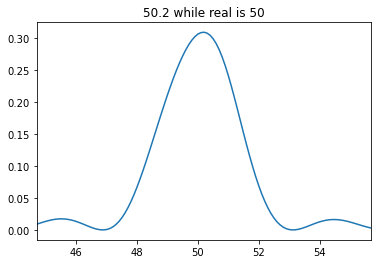

 50%|█████     | 6/12 [00:34<00:34,  5.72s/it]

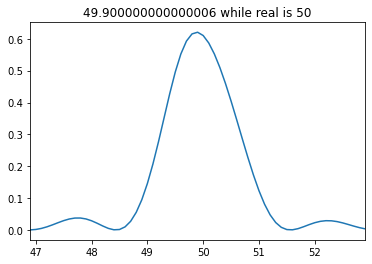

 58%|█████▊    | 7/12 [00:39<00:28,  5.72s/it]

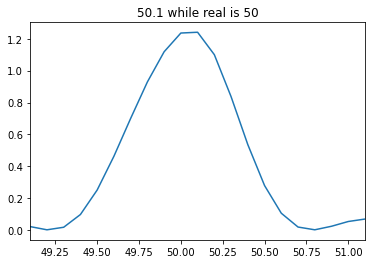

 58%|█████▊    | 7/12 [00:45<00:32,  6.49s/it]


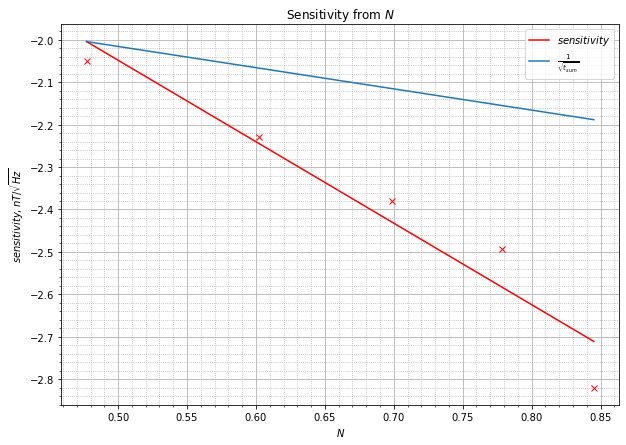

degrees of sensitivity from $N$:  
-1 x - 3.972e-16  
-1.92 x - 1.088  
-0.5 x - 9.93e-17


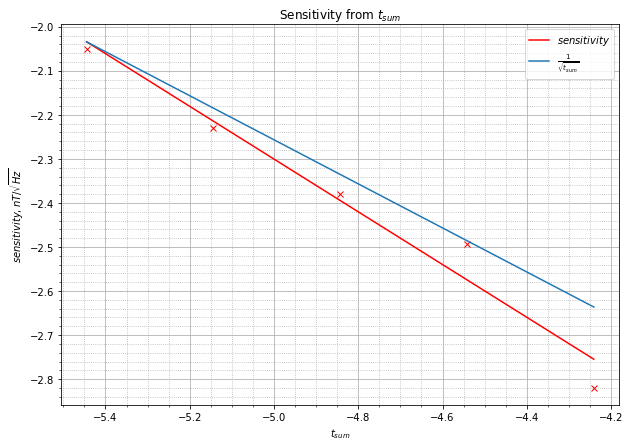

degrees of sensitivity from $t_{sum}$:  
-1 x - 3.178e-14  
-0.5984 x - 5.292  
-0.5 x - 1.589e-14
final sensitivity:  0.0 at 5.7 us last experiment delay time
First step was at 44.87 ns


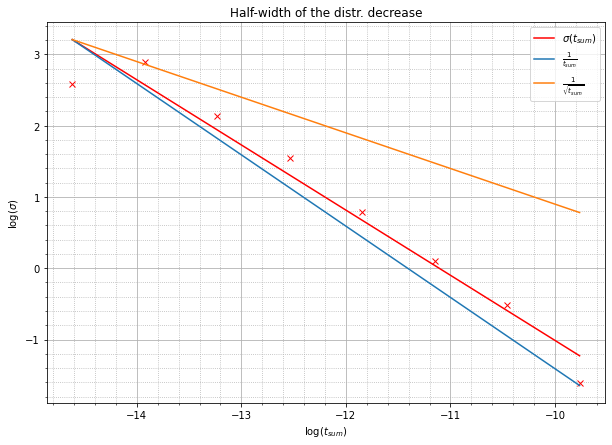

degrees of sigma:   
-1 x + 8.793e-15  
-0.914 x - 10.15  
-0.5 x + 4.396e-15
False


In [62]:
class ExperimentData:
    F = 50
    F_min = 0  # min field Tesla
    F_max = 100 # max field Tesla
    F_degree = 10**(-9)
    gained_degree = 1
    delta_F = 0.1  # accuracy of F defining
    fields_number = round( (F_max - F_min + delta_F) / delta_F ) # amount of discrete F meanings
    time_const = 2
    mu = 10 ** (5) * 927 * 10**(-26)  # magnetic moment of the qubit
    h = 6.62 * 10 ** (-34)  # plank's constant
    const = mu/h  # mu/h
    reverse = False
    t = math.pi/(const*F_degree*F_max/2)  # time of interaction in seconds
    t_init = t
    num_of_repetitions = 10  # repetitions for one experiment

    probability_distribution = [1 / fields_number] * fields_number
    
suc = False

experimentData = ExperimentData()
sigma = {}
a_from_t_sum = {} #sensitivity
a_from_step = {} #sensitivity
N = 12
t_sum = 0
epsilon = 10 ** (-3)
prev_sigma = experimentData.F_max - experimentData.F_min
flag = False
prev_step = 0
#
fig, ax = plt.subplots()
ax.minorticks_on()

#     print(experimentData.probability_distribution) # initial
print(experimentData.fields_number)
for step in tqdm(range(N)):

    bayesians_learning.renew_probalities(experimentData)
    #bayesians_learning.renew_probalities(qubit.randbin3(experimentData, F), experimentData)
    #bayesians_learning.renew_probalities(qubit.randbin2(experimentData, F), experimentData)
    #bayesians_learning.renew_probalities(ramsey_qubit.output(experimentData.t), experimentData)
    t_sum += experimentData.t * experimentData.num_of_repetitions



    x_peak, y_peak = find_peak(experimentData)
    left_peak_side, right_peak_side = localise_peak(experimentData)
    current_sigma = find_sigma(x_peak, y_peak, experimentData) / experimentData.gained_degree

    a_from_t_sum[t_sum] = current_sigma * (t_sum)**0.5
    a_from_step[step] = current_sigma * (t_sum) ** 0.5

    if current_sigma != 0:
        sigma[t_sum] = current_sigma

    if step <= 50 and prev_sigma == experimentData.F_max - experimentData.F_min and current_sigma != 0:
        flag = True

    if flag and \
            step - prev_step >= 1: # and \
            #prev_sigma + experimentData.delta_F/experimentData.gained_degree > 2 * current_sigma:# and \
            #experimentData.const * F * experimentData.F_degree * experimentData.t <= 3.14:
        prev_sigma = current_sigma
        prev_step = step
        experimentData.t *= experimentData.time_const
#         print(step)

    if flag and prev_sigma < current_sigma:
        prev_sigma = current_sigma

    if (step) % 1 == 0:
        plt.plot([experimentData.F_min + i*experimentData.delta_F for i in range(experimentData.fields_number)], 
                 [each for each in experimentData.probability_distribution]) # distr each 50 steps
        if step != 0:
            plt.xlim([x_peak-5*current_sigma, x_peak+5*current_sigma])
        plt.title(str(x_peak)+ ' while real is '+str(experimentData.F))
        plt.show()
#         if (step + 1) % 1 == 0:
#             print(bayesians_learning.integrate_distribution(experimentData), x_peak, y_peak, step, current_sigma, prev_sigma, t_sum, experimentData.const * experimentData.F * experimentData.t*experimentData.F_degree, flag) # checking ~ 1

#     if flag and current_sigma*experimentData.gained_degree <= 7*experimentData.delta_F:
#         plt.plot([experimentData.F_min + i * experimentData.delta_F for i in range(experimentData.fields_number)],
#                  [each for each in experimentData.probability_distribution])
# #             plt.show()
# #             plt.close()

#         fig, ax = plt.subplots()
#         ax.minorticks_on()

# #             expand(x_peak, y_peak, current_sigma, experimentData)
#         plt.plot([experimentData.F_min + i * experimentData.delta_F for i in range(experimentData.fields_number)],
#                  [each/10 for each in experimentData.probability_distribution])
# #             print(experimentData.probability_distribution)

    if y_peak >= 1.0 - epsilon or t_sum >= 100*10**(-3):
        break
        
    if x_peak == ExperimentData.F:
        suc = True

#plt.plot([experimentData.F_min + i*experimentData.delta_F for i in range(experimentData.fields_number)], experimentData.probability_distribution) # final distr
# plt.show()
#fig.savefig('distr_' + '.png', dpi=500)
plt.close()
# print(list(sigma.keys())[-1], list(sigma.values())[-1])

try:
    plotter.plotting_sensitivity(a_from_step, r'$N$')
except Exception:
    pass
try:
    plotter.plotting_sensitivity(a_from_t_sum, r'$t_{sum}$')
except Exception:
    pass

print("final sensitivity: ",  np.round(a_from_t_sum[t_sum]*ExperimentData.F_degree,2), 'at', np.round(experimentData.t*10**6,1), 'us last experiment delay time')
print('First step was at',  np.round(experimentData.t_init*10**9,2), 'ns')

x_peak, y_peak = find_peak(experimentData)

plotter.plotting(sigma)

    
print(suc)